In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [3]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()
        self.num_params = num_params
        self.init_params()

    def init_params(self):
        if num_params == 4:
            h_base = torch.tensor([4.4682, 4.2097, 0.5166, 0.4746])
            d_base = torch.tensor([4.2236, 4.1465, 1.3406, 1.4113])
            T_base = torch.tensor([3.4595, 3.2402, 0.2901, 1.2908])
        elif num_params == 8:
            h_base = torch.tensor([1.4939, 1.6136, 4.7730, 2.4916, 1.4080, 0.9018, 1.0605, 0.3997])
            d_base = torch.tensor([0.4433, 1.3525, 4.7553, 2.4729, 1.3782, 0.8179, 0.5103, 0.2444])
            T_base = torch.tensor([-0.9802, 0.2283, 4.0217, 1.5428, 0.3840, -0.4479, -1.0518, -1.8225])
        elif num_params == 12:
            h_base = torch.tensor([1.1507, 1.9843, 4.1558, 2.2380, 1.1598, 1.1832, 0.6838, 0.9808, 0.9599, 1.5397, -2.4526, 1.5903])
            d_base = torch.tensor([0.7290, 1.9051, 4.1505, 2.2302, 1.1365, 0.9365, 0.4517, 0.2054, 0.1066, 0.0487, 0.1452, 0.1571])
            T_base = torch.tensor([0.5358, 2.1906, 4.5437, 2.4850, 1.3502, 0.6904, -0.0415, -1.2596, -2.2509, -3.8104, -3.8233, -1.2061])
        elif num_params == 16:
            h_base = torch.tensor([0.8390, 1.2366, 3.2619, 1.9236, 0.7046, 2.2526, 1.2453, 1.0133, 0.7192, 0.7911, 0.8382, 0.6877, 0.6364, 1.0113, 1.7649, 0.7065])
            d_base = torch.tensor([0.7098, 0.0542, 3.2631, 1.9232, 0.1635, 2.2172, 1.2149, 0.9410, 0.6259, 0.5588, 0.4810, 0.3097, 0.2454, 0.1651, 0.7377, 0.0692])
            T_base = torch.tensor([1.6926, -3.4559, 5.9155, 4.1239, -2.5486, 1.9903, 0.7669, 0.1584, -0.4227, -0.8991, -1.4492, -1.9575, -2.3678, -2.8489, 0.3304, -3.6109])

        # Use Laplace noise
        self.h = nn.Parameter(h_base + torch.distributions.Laplace(0, 0.0001).sample(h_base.size()))
        self.d = nn.Parameter(d_base + torch.distributions.Laplace(0, 0.0001).sample(d_base.size()))
        self.T = nn.Parameter(T_base + torch.distributions.Laplace(0, 0.0001).sample(T_base.size()))
    
    def add_noise(self):
        self.h.data += torch.distributions.Laplace(0, 0.0001).sample(self.h.size())
        self.d.data += torch.distributions.Laplace(0, 0.0001).sample(self.d.size())
        self.T.data += torch.distributions.Laplace(0, 0.0001).sample(self.T.size())

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

Epoch 1/20000, Loss: 0.12474916130304337
Epoch 1001/20000, Loss: 0.12475214898586273
Epoch 2001/20000, Loss: 0.12475014477968216
Epoch 3001/20000, Loss: 0.12474662065505981
Epoch 4001/20000, Loss: 0.12474196404218674
Epoch 5001/20000, Loss: 0.12474492937326431
Epoch 6001/20000, Loss: 0.12473995983600616
Epoch 7001/20000, Loss: 0.12474679946899414
Epoch 8001/20000, Loss: 0.12475074082612991
Epoch 9001/20000, Loss: 0.12474764883518219
Epoch 10001/20000, Loss: 0.12474386394023895
Epoch 11001/20000, Loss: 0.12474224716424942
Epoch 12001/20000, Loss: 0.12473778426647186
Epoch 13001/20000, Loss: 0.12474872171878815
Epoch 14001/20000, Loss: 0.12474396824836731
Epoch 15001/20000, Loss: 0.12474318593740463
Epoch 16001/20000, Loss: 0.12475218623876572
Epoch 17001/20000, Loss: 0.12474635988473892
Epoch 18001/20000, Loss: 0.12474042922258377
Epoch 19001/20000, Loss: 0.1247485876083374
Loss values: [0.12474916130304337, 0.12474854290485382, 0.12474183738231659, 0.12474659830331802, 0.12474822998046

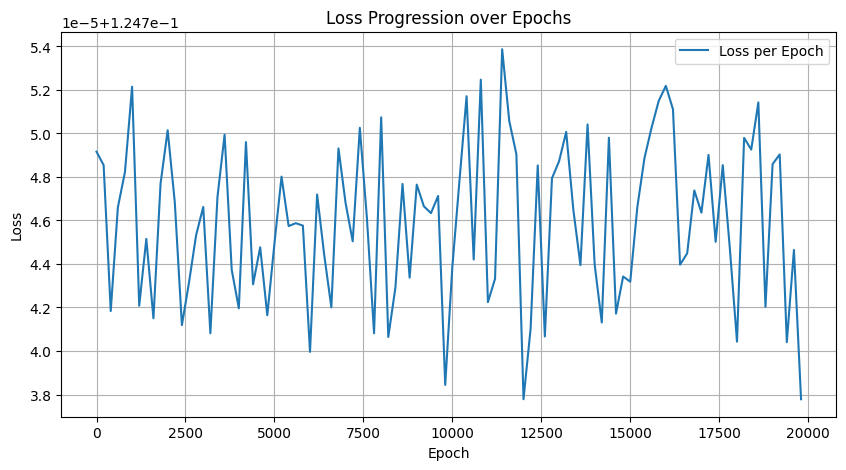

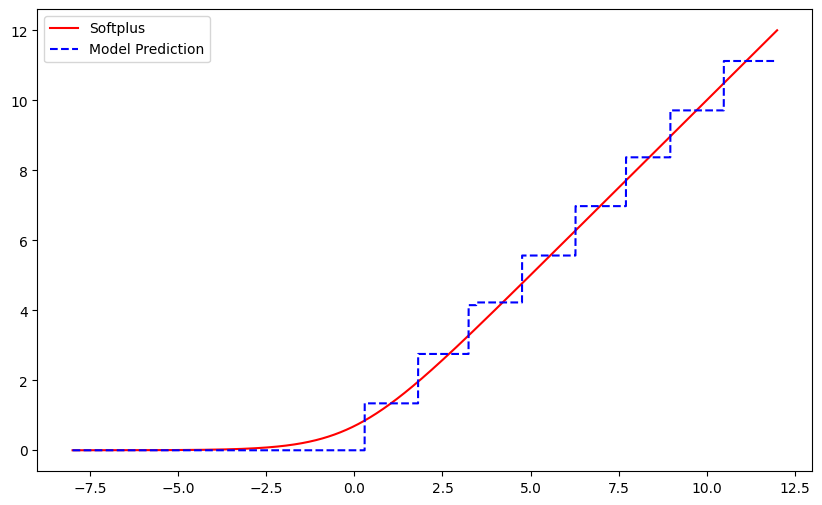

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    if epoch % 1000 == 0:
        model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.005818503443151712
Epoch 1001/20000, Loss: 0.005816347431391478
Epoch 2001/20000, Loss: 0.005817110650241375
Epoch 3001/20000, Loss: 0.0058169616386294365
Epoch 4001/20000, Loss: 0.00581663753837347
Epoch 5001/20000, Loss: 0.005818859674036503
Epoch 6001/20000, Loss: 0.005817297846078873
Epoch 7001/20000, Loss: 0.005817145574837923
Epoch 8001/20000, Loss: 0.005816448479890823
Epoch 9001/20000, Loss: 0.005817089229822159
Epoch 10001/20000, Loss: 0.005817664321511984
Epoch 11001/20000, Loss: 0.005816918332129717
Epoch 12001/20000, Loss: 0.00581745058298111
Epoch 13001/20000, Loss: 0.005816703662276268
Epoch 14001/20000, Loss: 0.005815865471959114
Epoch 15001/20000, Loss: 0.005817344877868891
Epoch 16001/20000, Loss: 0.005815909244120121
Epoch 17001/20000, Loss: 0.005816684570163488
Epoch 18001/20000, Loss: 0.005817680153995752
Epoch 19001/20000, Loss: 0.0058160643093287945
Loss values: [0.005818503443151712, 0.005816877353936434, 0.005816742777824402, 0.00581659423

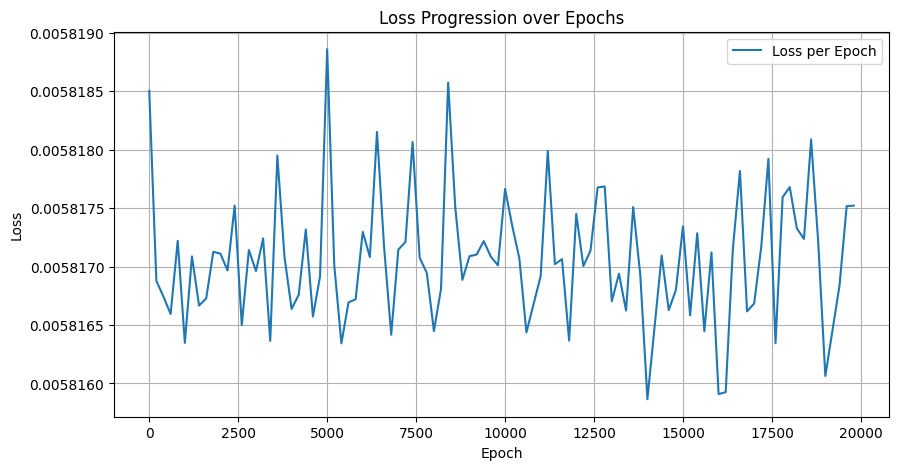

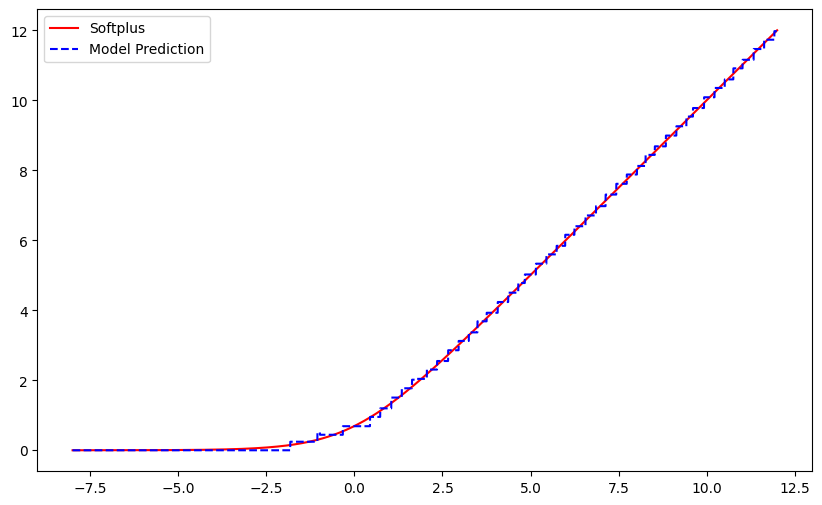

In [5]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    if epoch % 1000 == 0:
        model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.002250815974548459
Epoch 1001/20000, Loss: 0.00223072012886405
Epoch 2001/20000, Loss: 0.0022102436050772667
Epoch 3001/20000, Loss: 0.0022128261625766754
Epoch 4001/20000, Loss: 0.002214672276750207
Epoch 5001/20000, Loss: 0.0022207251749932766
Epoch 6001/20000, Loss: 0.002223319374024868
Epoch 7001/20000, Loss: 0.0022263010032474995
Epoch 8001/20000, Loss: 0.002228760626167059
Epoch 9001/20000, Loss: 0.0022322286386042833
Epoch 10001/20000, Loss: 0.0022360796574503183
Epoch 11001/20000, Loss: 0.002238634740933776
Epoch 12001/20000, Loss: 0.0022410510573536158
Epoch 13001/20000, Loss: 0.002245311625301838
Epoch 14001/20000, Loss: 0.002248200122267008
Epoch 15001/20000, Loss: 0.0022505095694214106
Epoch 16001/20000, Loss: 0.0022534860763698816
Epoch 17001/20000, Loss: 0.002255540806800127
Epoch 18001/20000, Loss: 0.0022584127727895975
Epoch 19001/20000, Loss: 0.002261405810713768
Loss values: [0.002250815974548459, 0.0022412228863686323, 0.002245852258056402, 0.0

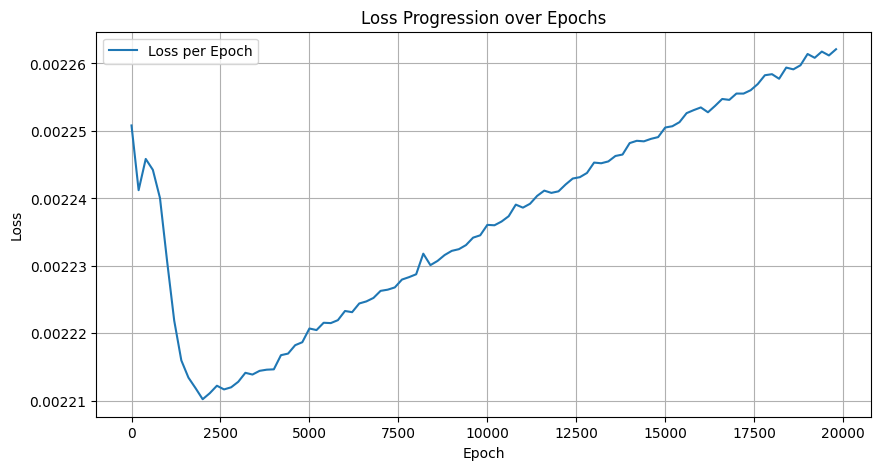

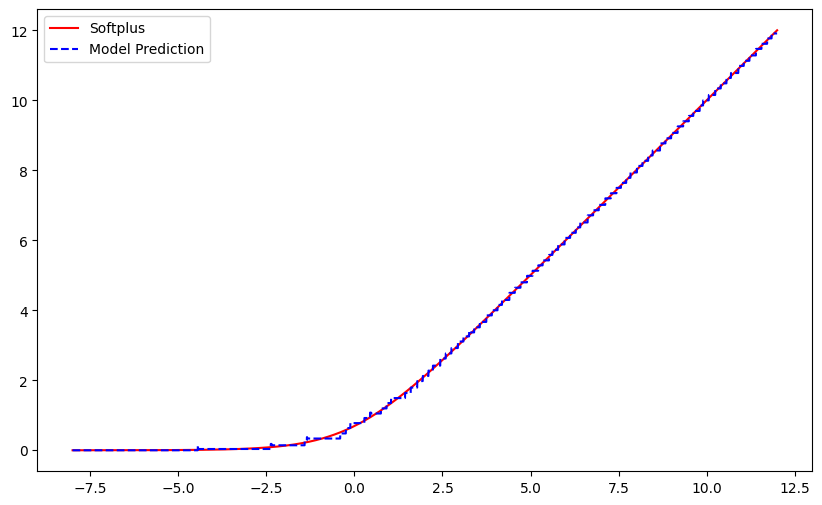

In [6]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    if epoch % 1000 == 0:
        model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.000976676819846034
Epoch 1001/20000, Loss: 0.0007685821619816124
Epoch 2001/20000, Loss: 0.0008217927534133196
Epoch 3001/20000, Loss: 0.0007117717759683728
Epoch 4001/20000, Loss: 0.0006768634193576872
Epoch 5001/20000, Loss: 0.0007095214095897973
Epoch 6001/20000, Loss: 0.0009809291223064065
Epoch 7001/20000, Loss: 0.0008150468929670751
Epoch 8001/20000, Loss: 0.0008473010966554284
Epoch 9001/20000, Loss: 0.0008658695733174682
Epoch 10001/20000, Loss: 0.0008491113549098372
Epoch 11001/20000, Loss: 0.0007708696648478508
Epoch 12001/20000, Loss: 0.0008576075779274106
Epoch 13001/20000, Loss: 0.0007868193206377327
Epoch 14001/20000, Loss: 0.0008317904430441558
Epoch 15001/20000, Loss: 0.0007623359560966492
Epoch 16001/20000, Loss: 0.0007972795283421874
Epoch 17001/20000, Loss: 0.0007810773677192628
Epoch 18001/20000, Loss: 0.0008038021624088287
Epoch 19001/20000, Loss: 0.0008093261858448386
Loss values: [0.000976676819846034, 0.0010485997190698981, 0.0011090697953

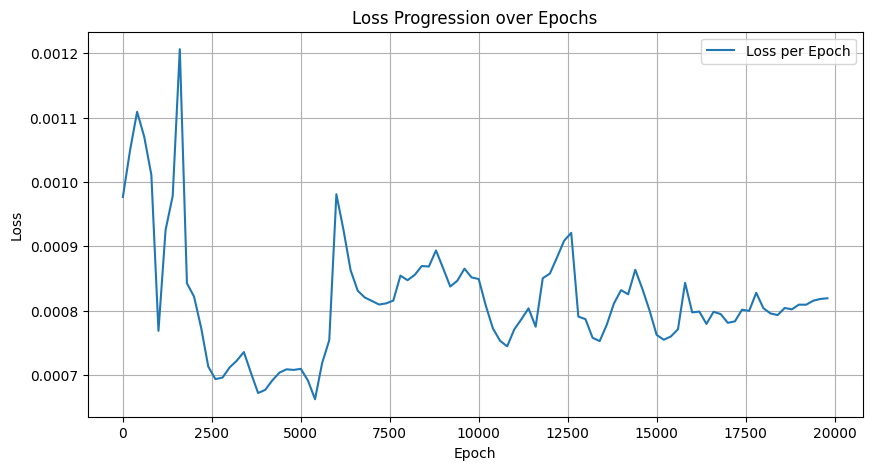

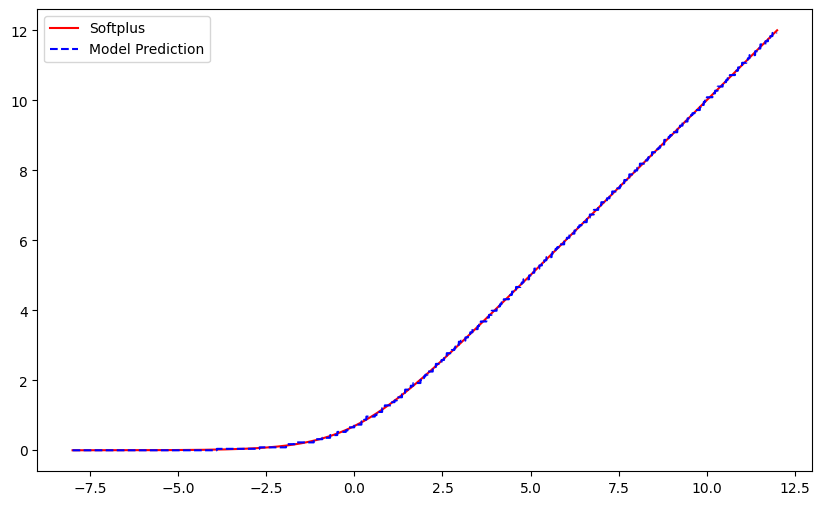

In [7]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    if epoch % 1000 == 0:
        model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()